In [1]:
import os
import random
import numpy as np
import pandas as pd
import multiprocessing
import tensorflow as tf
import keras
from scipy import signal
from itertools import starmap
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
DATA_PATH = '../../DataLake/stMary'
kf = KFold(n_splits=5)

2023-06-19 15:01:48.385239: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 15:01:48.432407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 15:01:49.071111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def generate_dataset(arg_pleths, arg_resps, fs=125, shift_factor=4):
    import copy
    dataset = []
    window_size = fs * 60 # 7500
    shift = int(window_size/shift_factor)
    samples_len = len(arg_pleths)

    cpy_resps = copy.deepcopy(arg_resps)
    cpy_pleths = copy.deepcopy(arg_pleths)

    for j in range(samples_len):
        rr = cpy_resps[j]; ppg = cpy_pleths[j]

        rr['offset'] = (rr['offset']-rr['offset'].min())/1000
        size_lim = int(fs * np.ceil(rr['offset'].max()))
        ppg = ppg[:size_lim]
        shift_n_times = int((len(ppg)-window_size)/shift)+1

        samp_rr = [len(rr.loc[ (rr['offset']>=0+(int(shift/fs)*i)) & ((rr['offset']<int(window_size/fs)+(int(shift/fs)*i))) ]) for i in range(shift_n_times)]
        samp_ppg = [ppg[0+(shift*i):window_size+(shift*i)] for i in range(shift_n_times)]

        for i in range(len(samp_ppg)):
            temp = []
            temp.append(samp_ppg[i])
            temp.append(samp_rr[i])
            dataset.append(temp)

    return dataset


def interpolation(x, input):
    x0 = int(np.floor(x))
    y0 = input[x0]
    x1 = int(np.ceil(x))
    y1 = input[x1]
    y = (y1-y0)*(x-x0) + y0
    return y


def signal_resample(input_signal, org_fs, new_fs, method='interpolation'):
    output_signal = []
    new_x = np.arange(0, len(input_signal), org_fs/new_fs)
    
    if method == 'interpolation': 
        interp = interpolation

    for x in new_x:
        y = interp(x, input_signal)
        output_signal.append(y)

    return np.asarray(output_signal)


def preprocessing(targets=None):
    print('Extract PLETH/RESP')
    pleths = [pd.read_csv(f'{DATA_PATH}/{sid}/pleth.csv', header=None, names=['sid', 'offset', 'pleth']).pleth.values for sid in targets.id.unique()]
    resps = [pd.read_csv(f'{DATA_PATH}/{sid}/respirationTimeline.csv', header=None, names=['sid', 'offset']) for sid in targets.id.unique()]

    # Before filtering: Check NaN
    for pleth in pleths:
        if any(np.isnan(pleth)):
            print('check')

    # Before filtering: Convert type as np.int16
    pleths = list(map(lambda pleth: pleth.astype(np.float32), pleths))


    print('Init Preprocessing: Filtering')
    taps = signal.firwin(numtaps=2000, cutoff=[0.5, 8.0], window='hamming', pass_zero=False, fs=125)
    w, h = signal.freqz(taps)
    pool = multiprocessing.Pool(processes=40)
    filtered_pleths = pool.starmap(signal.filtfilt, [(taps, 1.0, pleth) for pleth in pleths])
    pool.close()
    pool.join()


    print('Init Preprocessing: Windowing')
    dataset = generate_dataset(filtered_pleths, resps, shift_factor=60)


    print('Init Preprocessing: Resampling')
    pool = multiprocessing.Pool(processes=40)
    result = pool.starmap(signal_resample, [(pleth[0], 125, 30) for pleth in dataset])
    pool.close()
    pool.join()

    new_patient = []
    for i in range(len(dataset)):
        temp = []
        temp.append(result[i])
        temp.append(dataset[i][1])
        new_patient.append(temp)

    return new_patient


def prepare_modeling(dataset=None, batchsize=None):
    print(f'Prepare modeling')
    pleths = []
    resps = []
    for ppg, rr in dataset:
        pleths.append(ppg.astype(np.float32))
        resps.append(rr)
    pleths = np.asarray(pleths)
    resps = np.asarray(resps)
    print(pleths.shape, resps.shape)

    scaler = MinMaxScaler()
    scaled_pleths = np.asarray([scaler.fit_transform(pleth.reshape(-1,1)) for pleth in pleths])
    print(scaled_pleths.shape, type(scaled_pleths[0][0][0]))

    x, y = scaled_pleths[:], resps[:]

    return tf.data.Dataset.from_tensor_slices((x, y)).batch(batchsize)

### Train-Val-Test Split

In [3]:
# subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
# patients = subjects.loc[subjects['diagnosis']!='0']

# print('Init Sampling')
# rand_idx = list(range(100))
# random.seed(42)
# test_idx = random.sample(rand_idx, k=20)
# train_idx = list(set(rand_idx) - set(test_idx))
# train_patients = patients.iloc[train_idx]
# test_patients = patients.iloc[test_idx]
# print('Train-Test Split into 80:20 (Random seed 42)')
# print(train_idx, test_idx)

### Train-Val Split

In [3]:
subjects = pd.read_csv(f'{DATA_PATH}/patients.csv')
patients = subjects.loc[subjects['diagnosis']!='0']
train_patients = patients.sample(frac=1, random_state=42)
# display(patients.head())
# display(train_patients.head())

In [4]:
EPOCHS = 1000
BATCH_SIZE = 256
LR = 0.001
callbacks = [
    EarlyStopping(monitor='val_loss', patience=33),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
]

In [5]:
counter = 1
raw_dataset = {
    'train': [],
    'val': []
}
dataset = {
    'train': [],
    'val': []
}
for train_idx, val_idx in kf.split(train_patients):
    print(f'{counter}th K-fold')
    counter = counter + 1
    # 이렇게 하는 이유는 Train과 Validation을 완벽히 구별시키기 위함이다.
    X_train = preprocessing(train_patients.iloc[train_idx])
    X_val = preprocessing(train_patients.iloc[val_idx])
    print(f'Preprocessing finished: {len(X_train)} / {len(X_val)}')

    raw_dataset['train'].append(X_train)
    raw_dataset['val'].append(X_val)
    
    train_dataset = prepare_modeling(X_train, batchsize=BATCH_SIZE)
    val_dataset = prepare_modeling(X_val, batchsize=BATCH_SIZE)

    dataset['train'].append(train_dataset)
    dataset['val'].append(val_dataset)

1th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5180 / 1328
Prepare modeling
(5180, 1800) (5180,)
(5180, 1800, 1) <class 'numpy.float32'>


2023-06-19 15:08:19.021722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14353 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


Prepare modeling
(1328, 1800) (1328,)
(1328, 1800, 1) <class 'numpy.float32'>
2th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5214 / 1294
Prepare modeling
(5214, 1800) (5214,)
(5214, 1800, 1) <class 'numpy.float32'>
Prepare modeling
(1294, 1800) (1294,)
(1294, 1800, 1) <class 'numpy.float32'>
3th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessing: Windowing
Init Preprocessing: Resampling
Preprocessing finished: 5182 / 1326
Prepare modeling
(5182, 1800) (5182,)
(5182, 1800, 1) <class 'numpy.float32'>
Prepare modeling
(1326, 1800) (1326,)
(1326, 1800, 1) <class 'numpy.float32'>
4th K-fold
Extract PLETH/RESP
Init Preprocessing: Filtering
Init Preprocessi

# Model experiments

In [6]:
from model_src.Resnet import ResNet34
from model_src.Unet import Unet
from model_src.DilatedConv import RespDNN
from model_src.BianResnet import ResNet
from model_src.RespNet import RespNet
# from model_src.LSTM import VanillaLSTM

Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dilated Residual Neural Network V1

In [8]:
import os
import keras
import tensorflow as tf
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, AveragePooling1D, Dense, BatchNormalization, Activation, Add, Flatten, Concatenate
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')

class RespBlock(Model):
    def __init__(self, filters, *args, **kwargs):
        super(RespBlock, self).__init__(*args, **kwargs)
        self.conv1 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=1, padding='same')
        self.bn1 = BatchNormalization()

        self.conv2 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=2, padding='same')
        self.bn2 = BatchNormalization()

        self.conv3 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=3, padding='same')
        self.bn3 = BatchNormalization()

        # self.conv4 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=5, padding='same')
        # self.bn4 = BatchNormalization()

        self.conv1x1 = Conv1D(filters=filters*2, kernel_size=1, strides=1, padding='same')
        self.bn1x1 = BatchNormalization()


    def call(self, inputs, training=None, mask=None):
        x1 = self.conv1(inputs)
        x1 = self.bn1(x1)
        x1 = Activation('relu')(x1)

        x2 = self.conv2(inputs)
        x2 = self.bn2(x2)
        x2 = Activation('relu')(x2)
        
        x3 = self.conv3(inputs)
        x3 = self.bn3(x3)
        x3 = Activation('relu')(x3)

        # x4 = self.conv4(inputs)
        # x4 = self.bn4(x4)
        # x4 = Activation('relu')(x4)

        x = Add()([x1, x2, x3])
        x = Activation('relu')(x)
        
        x = self.conv1x1(x)
        x = self.bn1x1(x)

        if inputs.shape[-1] != 1:
            inputs = tf.reduce_mean(inputs, axis=-1, keepdims=True)
           
        x = Add()([x, inputs])
        return Activation('relu')(x)


class RespDNN2(Model):
    def __init__(self, *args, **kwargs):
        super(RespDNN2, self).__init__(*args, **kwargs)
        # self.respblk = [RespBlock(32*i) for i in np.arange(1, 4)]
        # self.dwnsamp = [Conv1D(32*i, kernel_size=3, strides=2, padding='same') for i in np.arange(1, 4)]
        self.respblk = [RespBlock(32*(2**i)) for i in range(3)]
        self.dwnsamp = [Conv1D(32*(2**i), kernel_size=3, strides=2, padding='same') for i in range(3)]
        self.bn = [BatchNormalization() for _ in range(3)]
        self.avgpool = AveragePooling1D(strides=2, padding='valid')
        self.dense1 = Dense(1000, activation='relu')
        self.dense2 = Dense(100, activation='relu')
        self.dense3 = Dense(1)

    @tf.function
    def call(self, inputs, training=None, mask=None):
        x = inputs
        # x = self.respblk[0](inputs) # (?, 1800, 32)

        # x = self.dwnsamp[0](x)
        # x = self.bn[0](x)
        # x = Activation('relu')(x) 
        # x = self.respblk[1](x) # (?, 900, 64)

        # x = self.dwnsamp[1](x)
        # x = self.bn[1](x)
        # x = Activation('relu')(x)
        # x = self.respblk[2](x) # (?, 450, 128)

        for i in range(3):
            x = self.respblk[i](x)
            x = self.dwnsamp[i](x)
            x = self.bn[i](x)
            x = Activation('relu')(x)

        x = self.avgpool(x)
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dilated Residual Neural Network V2

In [9]:
import os
import keras
import tensorflow as tf
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D, Dense, BatchNormalization, Activation, Add, Flatten, Concatenate
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')

class RespBlock(Model):
    def __init__(self, filters, *args, **kwargs):
        super(RespBlock, self).__init__(*args, **kwargs)
        self.conv11 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=1, padding='same')
        self.bn11 = BatchNormalization()
        self.conv12 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=1, padding='same')
        self.bn12 = BatchNormalization()

        self.conv2 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=2, padding='same')
        self.bn2 = BatchNormalization()

        self.conv3 = Conv1D(filters=filters, kernel_size=3, strides=1, dilation_rate=3, padding='same')
        self.bn3 = BatchNormalization()

        # self.conv1x1 = Conv1D(filters=filters*2, kernel_size=1, strides=1, padding='same')
        # self.bn1x1 = BatchNormalization()


    def call(self, inputs, training=None, mask=None):
        x1 = self.conv11(inputs)
        x1 = self.bn11(x1, training=training)
        x1 = Activation('relu')(x1)
        x1 = self.conv12(x1)
        x1 = self.bn12(x1, training=training)
        x1 = Activation('relu')(x1)

        x2 = self.conv2(inputs)
        x2 = self.bn2(x2, training=training)
        x2 = Activation('relu')(x2)
        
        x3 = self.conv3(inputs)
        x3 = self.bn3(x3, training=training)
        x3 = Activation('relu')(x3)

        x = Add()([x1, x2, x3])
        x = Activation('relu')(x)
        
        # x = self.conv1x1(x)
        # x = self.bn1x1(x, training=training)

        if inputs.shape[-1] != 1:
            inputs = tf.reduce_mean(inputs, axis=-1, keepdims=True)
           
        x = Add()([x, inputs])
        return Activation('relu')(x)


class RespDNN2(Model):
    def __init__(self, num_of_blocks=2, dwn_kernel_size=2, filters=8, *args, **kwargs):
        super(RespDNN2, self).__init__(*args, **kwargs)
        self.num_of_blocks = num_of_blocks

        self.respblk = [RespBlock(filters*(2**i)) for i in range(num_of_blocks)]
        self.dwnsamp = [Conv1D(filters*(2**i), kernel_size=dwn_kernel_size, strides=2, padding='same') for i in range(num_of_blocks)]
        self.bn = [BatchNormalization() for _ in range(num_of_blocks)]
        self.avgpool = AveragePooling1D(strides=2, padding='valid')
        # self.maxpool = MaxPooling1D(strides=2, padding='valid')
        self.dense1 = Dense(1000, activation='relu')
        self.dense2 = Dense(100, activation='relu')
        self.dense3 = Dense(1)


    def call(self, inputs, training=None, mask=None):
        x = inputs
        for i in range(self.num_of_blocks):
            x = self.respblk[i](x, training=training)
            x = self.dwnsamp[i](x)
            x = self.bn[i](x, training=training)
            x = Activation('relu')(x)

        x = self.avgpool(x)
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x


    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    

    def test_step(self, data):
        x, y = data

        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## LSTM

In [11]:
import os
import keras
import warnings
import tensorflow as tf
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Dense, BatchNormalization, Activation, Add, Flatten, Dropout, LSTM, Bidirectional, Concatenate
print(f'Is GPU Avaliable: {tf.config.list_physical_devices("GPU")}')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# warnings.filterwarnings(action='ignore')

class VanillaLSTM(Model):
    def __init__(self, *args, **kwargs):
        super(VanillaLSTM, self).__init__(*args, **kwargs)
        self.lstm1 = LSTM(516, activation='tanh', return_sequences=True, return_state=False)
        self.lstm2 = LSTM(256, activation='tanh')
        self.d1 = Dense(1000, activation='relu')
        self.d2 = Dense(1000, activation='relu')
        self.d3 = Dense(1)
    
    def call(self, inputs, *args, **kwargs):
        x = inputs
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)
    

class CNNLSTM(Model):
    def __init__(self, *args, **kwargs):
        super(CNNLSTM, self).__init__(*args, **kwargs)
        self.conv1 = Conv1D(filters=32, kernel_size=21)
        self.bn1 = BatchNormalization()
        self.conv2 = Conv1D(filters=32, kernel_size=21)
        self.bn2 = BatchNormalization()
        self.lstm1 = LSTM(units=32, activation='tanh')
        self.dense1 = Dense(32, activation='relu')
        self.dense2 = Dense(1)


    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = Activation('relu')(x)
        x = Dropout(0.2)(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = Activation('relu')(x)
        x = Dropout(0.2)(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)

        x = self.lstm1(x)
        x = Dropout(0.2)(x)

        x = self.dense1(x)
        return self.dense2(x)


    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    

    def test_step(self, data):
        x, y = data

        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    
class BiLSTM(Model):
    def __init__(self, *args, **kwargs):
        super(BiLSTM, self).__init__(*args, **kwargs)
        self.bilstm1 = Bidirectional(LSTM(64, activation='tanh', return_sequences=True))
        self.bilstm2 = Bidirectional(LSTM(32, activation='tanh'))
        self.d1 = Dense(1000, activation='relu')
        self.d2 = Dense(1000, activation='relu')
        self.d3 = Dense(1)

    
    def call(self, inputs, training=None, mask=None):
        x = self.bilstm1(inputs)
        x = self.bilstm2(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)


class BahdanauAttention(Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)


    def call(self, values, query, training=None, mask=None):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)
        ))

        attention_weights = tf.nn.softmax(score, axis=1)

        context = attention_weights * values
        context = tf.reduce_sum(context, axis=1)

        return context, attention_weights


class BiLSTMAttn(Model):
    def __init__(self, units_attn):
        super(BiLSTMAttn, self).__init__()
        self.bilstm1 = Bidirectional(LSTM(units=64, return_sequences=True))
        self.bilstm2 = Bidirectional(LSTM(units=32, return_sequences=True, return_state=True))
        self.attention = BahdanauAttention(units_attn)
        self.d1 = Dense(1000, activation='relu')
        self.d2 = Dense(1000, activation='relu')
        self.d3 = Dense(1)


    def call(self, inputs, training=None, mask=None):
        x = self.bilstm1(inputs)
        x, forward_h, _, backward_h, _ = self.bilstm2(x)
        state_h = Concatenate()([forward_h, backward_h])
        context, attention_weights = self.attention(x, state_h)
        x = self.d1(context)
        x = self.d2(x)
        x = self.d3(x)
        return x

Is GPU Avaliable: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
models = [ResNet()]
train_losses = []
val_losses = []

for i, model in enumerate(models):
    print(f'\nModel {i+1}th')
    print('====='*20)
    tmp_train_losses = []
    tmp_val_losses = []
    
    for i in range(5):
        print(f'{i+1}th K-fold')

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
            loss=keras.losses.MeanAbsoluteError(),
            metrics=keras.metrics.MeanAbsoluteError()
        )  

        callbacks.append(ModelCheckpoint(f'../models/230619-Bian-stmary-KF{i}', monitor='val_loss', save_best_only=True))
        
        history = model.fit(
            dataset['train'][i],
            epochs=EPOCHS,
            callbacks=callbacks,
            validation_data=dataset['val'][i]
        )

        val_loss_min_ix = np.argmin(history.history['val_loss'])
        tmp_train_losses.append(history.history['loss'][val_loss_min_ix])
        tmp_val_losses.append(history.history['val_loss'][val_loss_min_ix])
    
    train_losses.append(np.asarray(tmp_train_losses))
    val_losses.append(np.asarray(tmp_val_losses))
    print(f'{np.mean(train_losses)} ± {np.std(train_losses)}')
    print(f'{np.mean(val_losses)} ± {np.std(val_losses)}')


Model 1th
1th K-fold
Epoch 1/1000


2023-06-19 15:33:38.739230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5180]
	 [[{{node Placeholder/_1}}]]
2023-06-19 15:33:44.426973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-06-19 15:33:45.366725: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x560e077577e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-19 15:33:45.366792: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-06-19 15:33:45.379143: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-19 15:

21/21 [==============================] - ETA: 0s - loss: 7.4619 - mean_absolute_error: 7.4619

2023-06-19 15:33:53.867819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1328]
	 [[{{node Placeholder/_1}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.flo

INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 22s 405ms/step - loss: 7.4619 - mean_absolute_error: 7.4619 - val_loss: 16.9356 - val_mean_absolute_error: 16.9356 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - ETA: 0s - loss: 4.2649 - mean_absolute_error: 4.2649INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 359ms/step - loss: 4.2649 - mean_absolute_error: 4.2649 - val_loss: 15.2075 - val_mean_absolute_error: 15.2075 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - ETA: 0s - loss: 3.6396 - mean_absolute_error: 3.6396INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 359ms/step - loss: 3.6396 - mean_absolute_error: 3.6396 - val_loss: 14.1854 - val_mean_absolute_error: 14.1854 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - ETA: 0s - loss: 3.4311 - mean_absolute_error: 3.4311INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 359ms/step - loss: 3.4311 - mean_absolute_error: 3.4311 - val_loss: 12.5457 - val_mean_absolute_error: 12.5457 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - ETA: 0s - loss: 3.2847 - mean_absolute_error: 3.2847INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 371ms/step - loss: 3.2847 - mean_absolute_error: 3.2847 - val_loss: 10.0094 - val_mean_absolute_error: 10.0094 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - ETA: 0s - loss: 3.3335 - mean_absolute_error: 3.3335INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 366ms/step - loss: 3.3335 - mean_absolute_error: 3.3335 - val_loss: 8.9154 - val_mean_absolute_error: 8.9154 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - ETA: 0s - loss: 2.9986 - mean_absolute_error: 2.9986INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 367ms/step - loss: 2.9986 - mean_absolute_error: 2.9986 - val_loss: 8.8719 - val_mean_absolute_error: 8.8719 - lr: 0.0010
Epoch 8/1000
21/21 [==============================] - ETA: 0s - loss: 3.3853 - mean_absolute_error: 3.3853INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 368ms/step - loss: 3.3853 - mean_absolute_error: 3.3853 - val_loss: 8.3272 - val_mean_absolute_error: 8.3272 - lr: 0.0010
Epoch 9/1000
21/21 [==============================] - ETA: 0s - loss: 2.7638 - mean_absolute_error: 2.7638INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 8s 375ms/step - loss: 2.7638 - mean_absolute_error: 2.7638 - val_loss: 7.2594 - val_mean_absolute_error: 7.2594 - lr: 0.0010
Epoch 10/1000
21/21 [==============================] - ETA: 0s - loss: 2.9301 - mean_absolute_error: 2.9301INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 364ms/step - loss: 2.9301 - mean_absolute_error: 2.9301 - val_loss: 6.3390 - val_mean_absolute_error: 6.3390 - lr: 0.0010
Epoch 11/1000
21/21 [==============================] - ETA: 0s - loss: 2.7280 - mean_absolute_error: 2.7280INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 369ms/step - loss: 2.7280 - mean_absolute_error: 2.7280 - val_loss: 5.7697 - val_mean_absolute_error: 5.7697 - lr: 0.0010
Epoch 12/1000
21/21 [==============================] - 1s 42ms/step - loss: 2.8355 - mean_absolute_error: 2.8355 - val_loss: 6.3534 - val_mean_absolute_error: 6.3534 - lr: 0.0010
Epoch 13/1000
21/21 [==============================] - 1s 42ms/step - loss: 2.6046 - mean_absolute_error: 2.6046 - val_loss: 8.6137 - val_mean_absolute_error: 8.6137 - lr: 0.0010
Epoch 14/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.6796 - mean_absolute_error: 2.6796 - val_loss: 6.1972 - val_mean_absolute_error: 6.1972 - lr: 0.0010
Epoch 15/1000
21/21 [==============================] - 1s 46ms/step - loss: 2.5217 - mean_absolute_error: 2.5217 - val_loss: 6.1505 - val_mean_absolute_error: 6.1505 - lr: 0.0010
Epoch 16/1000
20/21 [===========================>..] - ETA: 0s - loss: 2.7791 - mean_absolute_error: 2.7791INFO:tensor

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 8s 380ms/step - loss: 2.7594 - mean_absolute_error: 2.7594 - val_loss: 5.0099 - val_mean_absolute_error: 5.0099 - lr: 0.0010
Epoch 17/1000
21/21 [==============================] - ETA: 0s - loss: 2.1582 - mean_absolute_error: 2.1582INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 371ms/step - loss: 2.1582 - mean_absolute_error: 2.1582 - val_loss: 4.2429 - val_mean_absolute_error: 4.2429 - lr: 0.0010
Epoch 18/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.0470 - mean_absolute_error: 2.0470 - val_loss: 4.4342 - val_mean_absolute_error: 4.4342 - lr: 0.0010
Epoch 19/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.3159 - mean_absolute_error: 2.3159 - val_loss: 6.4354 - val_mean_absolute_error: 6.4354 - lr: 0.0010
Epoch 20/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.6919 - mean_absolute_error: 2.6919 - val_loss: 6.7528 - val_mean_absolute_error: 6.7528 - lr: 0.0010
Epoch 21/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.5080 - mean_absolute_error: 2.5080 - val_loss: 5.2194 - val_mean_absolute_error: 5.2194 - lr: 0.0010
Epoch 22/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.2807 - mean_absolute_error: 2.2807 - val

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 8s 376ms/step - loss: 1.8845 - mean_absolute_error: 1.8845 - val_loss: 4.1440 - val_mean_absolute_error: 4.1440 - lr: 1.0000e-04
Epoch 37/1000
21/21 [==============================] - ETA: 0s - loss: 1.8187 - mean_absolute_error: 1.8187INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 370ms/step - loss: 1.8187 - mean_absolute_error: 1.8187 - val_loss: 4.0309 - val_mean_absolute_error: 4.0309 - lr: 1.0000e-04
Epoch 38/1000
21/21 [==============================] - ETA: 0s - loss: 1.7558 - mean_absolute_error: 1.7558INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 365ms/step - loss: 1.7558 - mean_absolute_error: 1.7558 - val_loss: 3.9561 - val_mean_absolute_error: 3.9561 - lr: 1.0000e-04
Epoch 39/1000
21/21 [==============================] - ETA: 0s - loss: 1.6929 - mean_absolute_error: 1.6929INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 366ms/step - loss: 1.6929 - mean_absolute_error: 1.6929 - val_loss: 3.8809 - val_mean_absolute_error: 3.8809 - lr: 1.0000e-04
Epoch 40/1000
21/21 [==============================] - ETA: 0s - loss: 1.6335 - mean_absolute_error: 1.6335INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 8s 373ms/step - loss: 1.6335 - mean_absolute_error: 1.6335 - val_loss: 3.8258 - val_mean_absolute_error: 3.8258 - lr: 1.0000e-04
Epoch 41/1000
21/21 [==============================] - ETA: 0s - loss: 1.5725 - mean_absolute_error: 1.5725INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 364ms/step - loss: 1.5725 - mean_absolute_error: 1.5725 - val_loss: 3.7863 - val_mean_absolute_error: 3.7863 - lr: 1.0000e-04
Epoch 42/1000
21/21 [==============================] - ETA: 0s - loss: 1.5129 - mean_absolute_error: 1.5129INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 366ms/step - loss: 1.5129 - mean_absolute_error: 1.5129 - val_loss: 3.7573 - val_mean_absolute_error: 3.7573 - lr: 1.0000e-04
Epoch 43/1000
21/21 [==============================] - ETA: 0s - loss: 1.4564 - mean_absolute_error: 1.4564INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 369ms/step - loss: 1.4564 - mean_absolute_error: 1.4564 - val_loss: 3.7308 - val_mean_absolute_error: 3.7308 - lr: 1.0000e-04
Epoch 44/1000
21/21 [==============================] - ETA: 0s - loss: 1.4047 - mean_absolute_error: 1.4047INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 8s 376ms/step - loss: 1.4047 - mean_absolute_error: 1.4047 - val_loss: 3.7042 - val_mean_absolute_error: 3.7042 - lr: 1.0000e-04
Epoch 45/1000
21/21 [==============================] - ETA: 0s - loss: 1.3530 - mean_absolute_error: 1.3530INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 364ms/step - loss: 1.3530 - mean_absolute_error: 1.3530 - val_loss: 3.6882 - val_mean_absolute_error: 3.6882 - lr: 1.0000e-04
Epoch 46/1000
21/21 [==============================] - ETA: 0s - loss: 1.3045 - mean_absolute_error: 1.3045INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 364ms/step - loss: 1.3045 - mean_absolute_error: 1.3045 - val_loss: 3.6769 - val_mean_absolute_error: 3.6769 - lr: 1.0000e-04
Epoch 47/1000
19/21 [==========================>...] - ETA: 0s - loss: 1.2003 - mean_absolute_error: 1.2003INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 362ms/step - loss: 1.2580 - mean_absolute_error: 1.2580 - val_loss: 3.6655 - val_mean_absolute_error: 3.6655 - lr: 1.0000e-04
Epoch 48/1000
21/21 [==============================] - ETA: 0s - loss: 1.2145 - mean_absolute_error: 1.2145INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 364ms/step - loss: 1.2145 - mean_absolute_error: 1.2145 - val_loss: 3.6457 - val_mean_absolute_error: 3.6457 - lr: 1.0000e-04
Epoch 49/1000
21/21 [==============================] - 1s 41ms/step - loss: 1.1662 - mean_absolute_error: 1.1662 - val_loss: 3.6463 - val_mean_absolute_error: 3.6463 - lr: 1.0000e-04
Epoch 50/1000
21/21 [==============================] - ETA: 0s - loss: 1.1312 - mean_absolute_error: 1.1312INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 371ms/step - loss: 1.1312 - mean_absolute_error: 1.1312 - val_loss: 3.6395 - val_mean_absolute_error: 3.6395 - lr: 1.0000e-04
Epoch 51/1000
21/21 [==============================] - ETA: 0s - loss: 1.0995 - mean_absolute_error: 1.0995INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 366ms/step - loss: 1.0995 - mean_absolute_error: 1.0995 - val_loss: 3.6268 - val_mean_absolute_error: 3.6268 - lr: 1.0000e-04
Epoch 52/1000
21/21 [==============================] - ETA: 0s - loss: 1.0613 - mean_absolute_error: 1.0613INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 360ms/step - loss: 1.0613 - mean_absolute_error: 1.0613 - val_loss: 3.6231 - val_mean_absolute_error: 3.6231 - lr: 1.0000e-04
Epoch 53/1000
21/21 [==============================] - 1s 39ms/step - loss: 1.0187 - mean_absolute_error: 1.0187 - val_loss: 3.6307 - val_mean_absolute_error: 3.6307 - lr: 1.0000e-04
Epoch 54/1000
21/21 [==============================] - 1s 41ms/step - loss: 0.9909 - mean_absolute_error: 0.9909 - val_loss: 3.6314 - val_mean_absolute_error: 3.6314 - lr: 1.0000e-04
Epoch 55/1000
21/21 [==============================] - ETA: 0s - loss: 0.9872 - mean_absolute_error: 0.9872INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366414b0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366418d0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e590>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3666e1d0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b14b0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366b32e0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366d9150>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd366daf80>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364fcd90>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364febc0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651ca30>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3651e860>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36548670>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3654a4a0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656c370>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656e1a0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3656ff70>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36595de0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36597c10>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b5a80>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365b7850>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365dd6c0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd365df4f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36401360>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36403130>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36424fa0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36426dd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644cca0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3644ea70>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646c910>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3646e740>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364945b0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36496380>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bc1f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364be020>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364bfe50>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e1c60>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd364e3a90>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36301900>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36303730>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36329570>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3632b3a0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36351270>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363530a0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370eb0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36372ce0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36394b50>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36396980>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363bc790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd363be5c0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361e8430>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd361ea260>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36204070>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36205ea0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36207cd0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622db40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3622f910>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36255780>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362575b0>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627d420>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3627f1f0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a5060>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362a6e30>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c4ca0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd362c6a70>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360ec8e0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


21/21 [==============================] - 7s 366ms/step - loss: 0.9872 - mean_absolute_error: 0.9872 - val_loss: 3.6157 - val_mean_absolute_error: 3.6157 - lr: 1.0000e-04
Epoch 56/1000
21/21 [==============================] - 1s 41ms/step - loss: 0.9516 - mean_absolute_error: 0.9516 - val_loss: 3.6392 - val_mean_absolute_error: 3.6392 - lr: 1.0000e-04
Epoch 57/1000
21/21 [==============================] - 1s 41ms/step - loss: 0.9142 - mean_absolute_error: 0.9142 - val_loss: 3.6501 - val_mean_absolute_error: 3.6501 - lr: 1.0000e-04
Epoch 58/1000
21/21 [==============================] - 1s 41ms/step - loss: 0.9079 - mean_absolute_error: 0.9079 - val_loss: 3.6715 - val_mean_absolute_error: 3.6715 - lr: 1.0000e-04
Epoch 59/1000
21/21 [==============================] - 1s 40ms/step - loss: 0.9123 - mean_absolute_error: 0.9123 - val_loss: 3.6293 - val_mean_absolute_error: 3.6293 - lr: 1.0000e-04
Epoch 60/1000
21/21 [==============================] - 1s 39ms/step - loss: 0.9208 - mean_absolute

2023-06-19 15:38:25.998129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5214]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - ETA: 0s - loss: 3.5526 - mean_absolute_error: 3.5526

2023-06-19 15:38:37.050242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1294]
	 [[{{node Placeholder/_1}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


21/21 [==============================] - 18s 405ms/step - loss: 3.5526 - mean_absolute_error: 3.5526 - val_loss: 3.7076 - val_mean_absolute_error: 3.7076 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - ETA: 0s - loss: 2.6390 - mean_absolute_error: 2.6390INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


21/21 [==============================] - 8s 376ms/step - loss: 2.6390 - mean_absolute_error: 2.6390 - val_loss: 3.7068 - val_mean_absolute_error: 3.7068 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - ETA: 0s - loss: 2.0650 - mean_absolute_error: 2.0650INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


21/21 [==============================] - 14s 695ms/step - loss: 2.0650 - mean_absolute_error: 2.0650 - val_loss: 3.0970 - val_mean_absolute_error: 3.0970 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 1s 37ms/step - loss: 1.7768 - mean_absolute_error: 1.7768 - val_loss: 4.4682 - val_mean_absolute_error: 4.4682 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 1s 41ms/step - loss: 1.7633 - mean_absolute_error: 1.7633 - val_loss: 3.3548 - val_mean_absolute_error: 3.3548 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.1452 - mean_absolute_error: 2.1452 - val_loss: 3.7360 - val_mean_absolute_error: 3.7360 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.1456 - mean_absolute_error: 2.1456 - val_loss: 3.3808 - val_mean_absolute_error: 3.3808 - lr: 0.0010
Epoch 8/1000
21/21 [==============================] - ETA: 0s - loss: 2.0203 - mean_absolute_error: 2.0203INFO:tensorflow

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd206d0>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872ca60>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a8f370>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b772620>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7708e0>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ab7010>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd359faaa0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd360d63b0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01c7ac0>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce013c2e0>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423f6d0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3423e0e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34533ee0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345307f0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3450b1c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34508af0>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd300>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd345288b0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3452aad0>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34528370>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35caa110>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ca9240>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b369d20>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36370ac0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b998fd0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cc49d0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341cd0c0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc84f0>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34214fa0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6532b0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd343b5d20>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b6010c0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b8f3130>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df425f0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd29240>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba7610>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342751e0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de89720>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2deca3e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02a2950>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35a27df0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b645c90>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f74c0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9480>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fcd90>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00ff8e0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346b0df0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf6800>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35cf42b0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a6aa0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e16d3f0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce80d7ca0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027ca00>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168130>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3416ad40>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34168340>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c482e0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4acb0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c4bd00>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b4ae30>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010cfa0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34187760>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34186830>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b68a3e0>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b3a00>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344b16c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


21/21 [==============================] - 14s 719ms/step - loss: 2.0203 - mean_absolute_error: 2.0203 - val_loss: 2.8038 - val_mean_absolute_error: 2.8038 - lr: 0.0010
Epoch 9/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.7671 - mean_absolute_error: 1.7671 - val_loss: 3.7173 - val_mean_absolute_error: 3.7173 - lr: 0.0010
Epoch 10/1000
21/21 [==============================] - 1s 38ms/step - loss: 1.6900 - mean_absolute_error: 1.6900 - val_loss: 3.4184 - val_mean_absolute_error: 3.4184 - lr: 0.0010
Epoch 11/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.5246 - mean_absolute_error: 2.5246 - val_loss: 3.2574 - val_mean_absolute_error: 3.2574 - lr: 0.0010
Epoch 12/1000
21/21 [==============================] - 1s 38ms/step - loss: 2.5291 - mean_absolute_error: 2.5291 - val_loss: 4.4724 - val_mean_absolute_error: 4.4724 - lr: 0.0010
Epoch 13/1000
21/21 [==============================] - 1s 37ms/step - loss: 3.2481 - mean_absolute_error: 3.2481 - val

2023-06-19 15:39:51.552699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5182]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - ETA: 0s - loss: 2.5030 - mean_absolute_error: 2.5030

2023-06-19 15:40:02.734124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1326]
	 [[{{node Placeholder/_1}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 19s 434ms/step - loss: 2.5030 - mean_absolute_error: 2.5030 - val_loss: 4.3941 - val_mean_absolute_error: 4.3941 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - ETA: 0s - loss: 2.0085 - mean_absolute_error: 2.0085INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 7s 347ms/step - loss: 2.0085 - mean_absolute_error: 2.0085 - val_loss: 3.3554 - val_mean_absolute_error: 3.3554 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - ETA: 0s - loss: 1.6414 - mean_absolute_error: 1.6414INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 21s 1s/step - loss: 1.6414 - mean_absolute_error: 1.6414 - val_loss: 2.5655 - val_mean_absolute_error: 2.5655 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.7862 - mean_absolute_error: 1.7862 - val_loss: 3.5824 - val_mean_absolute_error: 3.5824 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.6324 - mean_absolute_error: 1.6324 - val_loss: 3.0587 - val_mean_absolute_error: 3.0587 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 1s 39ms/step - loss: 1.7042 - mean_absolute_error: 1.7042 - val_loss: 2.8468 - val_mean_absolute_error: 2.8468 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - 1s 39ms/step - loss: 2.2489 - mean_absolute_error: 2.2489 - val_loss: 3.1432 - val_mean_absolute_error: 3.1432 - lr: 0.0010
Epoch 8/1000
21/21 [==============================] - 1s 39ms/step - loss: 1.8513 - mean_absolute_error: 1.8513 - val_loss: 

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 21s 1s/step - loss: 1.5106 - mean_absolute_error: 1.5106 - val_loss: 2.3299 - val_mean_absolute_error: 2.3299 - lr: 0.0010
Epoch 11/1000
21/21 [==============================] - 1s 41ms/step - loss: 1.6595 - mean_absolute_error: 1.6595 - val_loss: 3.6279 - val_mean_absolute_error: 3.6279 - lr: 0.0010
Epoch 12/1000
21/21 [==============================] - 1s 40ms/step - loss: 3.3402 - mean_absolute_error: 3.3402 - val_loss: 4.4223 - val_mean_absolute_error: 4.4223 - lr: 0.0010
Epoch 13/1000
21/21 [==============================] - 1s 39ms/step - loss: 3.6672 - mean_absolute_error: 3.6672 - val_loss: 6.2346 - val_mean_absolute_error: 6.2346 - lr: 0.0010
Epoch 14/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.6322 - mean_absolute_error: 2.6322 - val_loss: 3.6079 - val_mean_absolute_error: 3.6079 - lr: 0.0010
Epoch 15/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.4215 - mean_absolute_error: 2.4215 - val_l

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 21s 1s/step - loss: 1.1034 - mean_absolute_error: 1.1034 - val_loss: 2.3172 - val_mean_absolute_error: 2.3172 - lr: 1.0000e-04
Epoch 26/1000
21/21 [==============================] - ETA: 0s - loss: 1.0244 - mean_absolute_error: 1.0244INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 20s 1s/step - loss: 1.0244 - mean_absolute_error: 1.0244 - val_loss: 2.3040 - val_mean_absolute_error: 2.3040 - lr: 1.0000e-04
Epoch 27/1000
21/21 [==============================] - ETA: 0s - loss: 0.9648 - mean_absolute_error: 0.9648INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 21s 1s/step - loss: 0.9648 - mean_absolute_error: 0.9648 - val_loss: 2.3019 - val_mean_absolute_error: 2.3019 - lr: 1.0000e-04
Epoch 28/1000
21/21 [==============================] - ETA: 0s - loss: 0.9249 - mean_absolute_error: 0.9249INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF0/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF1/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b468940>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46b1c0>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5abfd0>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff326b0>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5a0220>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b508880>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44b20>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd44d00>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60509600>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60508b20>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68113df0>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68111780>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6dd50>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbccff6e6b0>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b31a710>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b319450>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b2a8f0>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5bd9b70>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02d9120>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68262d70>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0378700>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce037a7d0>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce02ac6d0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601828c0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60180100>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35ba5660>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce8057e20>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7f850>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b658940>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346bd3f0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c04310>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c05600>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce01f31c0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1dc60>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f1f6d0>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605ed0f0>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059ded0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34351540>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bdd0ee0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b66260>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b949ba0>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b94b940>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce027b610>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce0278430>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce00fea10>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68609510>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce010eef0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9ed0>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd346c9240>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b95ab0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3bebc0>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b821db0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7eb1f0>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84e80>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2df84a60>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b52ffd0>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34253ac0>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852d5a0>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68506b60>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fd030>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2e004c70>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b7f4b20>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683b37c0>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826e440>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826dfc0>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6826f7c0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF2/assets


21/21 [==============================] - 20s 1s/step - loss: 0.9249 - mean_absolute_error: 0.9249 - val_loss: 2.2984 - val_mean_absolute_error: 2.2984 - lr: 1.0000e-04
Epoch 29/1000
21/21 [==============================] - 1s 39ms/step - loss: 0.8944 - mean_absolute_error: 0.8944 - val_loss: 2.3111 - val_mean_absolute_error: 2.3111 - lr: 1.0000e-04
Epoch 30/1000
21/21 [==============================] - 1s 41ms/step - loss: 0.8689 - mean_absolute_error: 0.8689 - val_loss: 2.3197 - val_mean_absolute_error: 2.3197 - lr: 1.0000e-04
Epoch 31/1000
21/21 [==============================] - 1s 41ms/step - loss: 0.8458 - mean_absolute_error: 0.8458 - val_loss: 2.3340 - val_mean_absolute_error: 2.3340 - lr: 1.0000e-04
Epoch 32/1000
21/21 [==============================] - 1s 39ms/step - loss: 0.8241 - mean_absolute_error: 0.8241 - val_loss: 2.3360 - val_mean_absolute_error: 2.3360 - lr: 1.0000e-04
Epoch 33/1000
21/21 [==============================] - 1s 40ms/step - loss: 0.8062 - mean_absolute_e

2023-06-19 15:43:07.857234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5262]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - ETA: 0s - loss: 1.7900 - mean_absolute_error: 1.7900

2023-06-19 15:43:19.265009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1246]
	 [[{{node Placeholder/_1}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 19s 435ms/step - loss: 1.7900 - mean_absolute_error: 1.7900 - val_loss: 3.0980 - val_mean_absolute_error: 3.0980 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - 1s 39ms/step - loss: 2.1796 - mean_absolute_error: 2.1796 - val_loss: 5.0613 - val_mean_absolute_error: 5.0613 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.1172 - mean_absolute_error: 2.1172 - val_loss: 5.0703 - val_mean_absolute_error: 5.0703 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 1s 38ms/step - loss: 1.5976 - mean_absolute_error: 1.5976 - val_loss: 3.2969 - val_mean_absolute_error: 3.2969 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - ETA: 0s - loss: 1.7068 - mean_absolute_error: 1.7068INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 7s 372ms/step - loss: 1.7068 - mean_absolute_error: 1.7068 - val_loss: 3.0456 - val_mean_absolute_error: 3.0456 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.7464 - mean_absolute_error: 1.7464 - val_loss: 3.7166 - val_mean_absolute_error: 3.7166 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - ETA: 0s - loss: 1.9537 - mean_absolute_error: 1.9537INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 8s 378ms/step - loss: 1.9537 - mean_absolute_error: 1.9537 - val_loss: 2.7919 - val_mean_absolute_error: 2.7919 - lr: 0.0010
Epoch 8/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.7586 - mean_absolute_error: 1.7586 - val_loss: 4.5740 - val_mean_absolute_error: 4.5740 - lr: 0.0010
Epoch 9/1000
21/21 [==============================] - 1s 39ms/step - loss: 1.4782 - mean_absolute_error: 1.4782 - val_loss: 2.9734 - val_mean_absolute_error: 2.9734 - lr: 0.0010
Epoch 10/1000
21/21 [==============================] - 1s 41ms/step - loss: 1.7799 - mean_absolute_error: 1.7799 - val_loss: 3.5468 - val_mean_absolute_error: 3.5468 - lr: 0.0010
Epoch 11/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.0427 - mean_absolute_error: 2.0427 - val_loss: 4.0808 - val_mean_absolute_error: 4.0808 - lr: 0.0010
Epoch 12/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.8806 - mean_absolute_error: 2.8806 - val_l

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 8s 384ms/step - loss: 1.3708 - mean_absolute_error: 1.3708 - val_loss: 2.7599 - val_mean_absolute_error: 2.7599 - lr: 1.0000e-04
Epoch 21/1000
21/21 [==============================] - ETA: 0s - loss: 1.2510 - mean_absolute_error: 1.2510INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 8s 379ms/step - loss: 1.2510 - mean_absolute_error: 1.2510 - val_loss: 2.7103 - val_mean_absolute_error: 2.7103 - lr: 1.0000e-04
Epoch 22/1000
21/21 [==============================] - ETA: 0s - loss: 1.1877 - mean_absolute_error: 1.1877INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 7s 350ms/step - loss: 1.1877 - mean_absolute_error: 1.1877 - val_loss: 2.6751 - val_mean_absolute_error: 2.6751 - lr: 1.0000e-04
Epoch 23/1000
21/21 [==============================] - ETA: 0s - loss: 1.1345 - mean_absolute_error: 1.1345INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 8s 380ms/step - loss: 1.1345 - mean_absolute_error: 1.1345 - val_loss: 2.6692 - val_mean_absolute_error: 2.6692 - lr: 1.0000e-04
Epoch 24/1000
21/21 [==============================] - 1s 36ms/step - loss: 1.0876 - mean_absolute_error: 1.0876 - val_loss: 2.6698 - val_mean_absolute_error: 2.6698 - lr: 1.0000e-04
Epoch 25/1000
21/21 [==============================] - ETA: 0s - loss: 1.0437 - mean_absolute_error: 1.0437INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0595270>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818dc00>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6818c400>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c7cb50>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc682ac760>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c0caf0>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd36124bb0>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dca09d0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6059c580>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd367d2a40>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dd7f880>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35e378e0>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3439aaa0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b46bf10>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683af7c0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84100940>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9a20>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a2680>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6852f310>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60135780>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8465d7e0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68131750>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130400>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464f1f0>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6013b0a0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b908ee0>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b3190>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc605b0b20>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846495d0>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6051b7c0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60518ee0>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b2b100>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6058b4f0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60588f40>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6022ba90>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60229630>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b3353c0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6872e6b0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd347181c0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3471b760>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60681c60>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de8a0e0>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68556a40>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6014fac0>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60276ad0>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6016cca0>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34530ac0>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0398a60>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddac790>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60536ef0>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60537340>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60282500>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60280880>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc602493f0>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc6047a3e0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60478910>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60602140>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60395060>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60397a90>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c86a0>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604cbf40>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc604c8f70>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68276e90>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd342a4130>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de92d10>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2de907f0>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF3/assets


21/21 [==============================] - 8s 388ms/step - loss: 1.0437 - mean_absolute_error: 1.0437 - val_loss: 2.6679 - val_mean_absolute_error: 2.6679 - lr: 1.0000e-04
Epoch 26/1000
21/21 [==============================] - 1s 38ms/step - loss: 1.0066 - mean_absolute_error: 1.0066 - val_loss: 2.6744 - val_mean_absolute_error: 2.6744 - lr: 1.0000e-04
Epoch 27/1000
21/21 [==============================] - 1s 38ms/step - loss: 0.9726 - mean_absolute_error: 0.9726 - val_loss: 2.6711 - val_mean_absolute_error: 2.6711 - lr: 1.0000e-04
Epoch 28/1000
21/21 [==============================] - 1s 37ms/step - loss: 0.9421 - mean_absolute_error: 0.9421 - val_loss: 2.6867 - val_mean_absolute_error: 2.6867 - lr: 1.0000e-04
Epoch 29/1000
21/21 [==============================] - 1s 40ms/step - loss: 0.9161 - mean_absolute_error: 0.9161 - val_loss: 2.7023 - val_mean_absolute_error: 2.7023 - lr: 1.0000e-04
Epoch 30/1000
21/21 [==============================] - 1s 41ms/step - loss: 0.8922 - mean_absolute

2023-06-19 15:45:01.513015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5194]
	 [[{{node Placeholder/_1}}]]


21/21 [==============================] - ETA: 0s - loss: 1.6358 - mean_absolute_error: 1.6358

2023-06-19 15:45:12.564220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1314]
	 [[{{node Placeholder/_1}}]]


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


21/21 [==============================] - 18s 417ms/step - loss: 1.6358 - mean_absolute_error: 1.6358 - val_loss: 4.3045 - val_mean_absolute_error: 4.3045 - lr: 0.0010
Epoch 2/1000
21/21 [==============================] - ETA: 0s - loss: 1.9232 - mean_absolute_error: 1.9232INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


21/21 [==============================] - 8s 376ms/step - loss: 1.9232 - mean_absolute_error: 1.9232 - val_loss: 3.0424 - val_mean_absolute_error: 3.0424 - lr: 0.0010
Epoch 3/1000
21/21 [==============================] - 1s 38ms/step - loss: 1.6436 - mean_absolute_error: 1.6436 - val_loss: 4.6195 - val_mean_absolute_error: 4.6195 - lr: 0.0010
Epoch 4/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.7798 - mean_absolute_error: 1.7798 - val_loss: 3.6359 - val_mean_absolute_error: 3.6359 - lr: 0.0010
Epoch 5/1000
21/21 [==============================] - 1s 39ms/step - loss: 1.4487 - mean_absolute_error: 1.4487 - val_loss: 3.3599 - val_mean_absolute_error: 3.3599 - lr: 0.0010
Epoch 6/1000
21/21 [==============================] - 1s 37ms/step - loss: 1.9354 - mean_absolute_error: 1.9354 - val_loss: 5.4776 - val_mean_absolute_error: 5.4776 - lr: 0.0010
Epoch 7/1000
21/21 [==============================] - ETA: 0s - loss: 1.9995 - mean_absolute_error: 1.9995INFO:tensorflow:

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


21/21 [==============================] - 7s 335ms/step - loss: 1.9995 - mean_absolute_error: 1.9995 - val_loss: 2.9416 - val_mean_absolute_error: 2.9416 - lr: 0.0010
Epoch 8/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.4756 - mean_absolute_error: 1.4756 - val_loss: 3.0758 - val_mean_absolute_error: 3.0758 - lr: 0.0010
Epoch 9/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.2320 - mean_absolute_error: 2.2320 - val_loss: 5.0282 - val_mean_absolute_error: 5.0282 - lr: 0.0010
Epoch 10/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.6079 - mean_absolute_error: 2.6079 - val_loss: 4.4859 - val_mean_absolute_error: 4.4859 - lr: 0.0010
Epoch 11/1000
21/21 [==============================] - 1s 40ms/step - loss: 2.8569 - mean_absolute_error: 2.8569 - val_loss: 6.7814 - val_mean_absolute_error: 6.7814 - lr: 0.0010
Epoch 12/1000
21/21 [==============================] - 1s 41ms/step - loss: 2.5669 - mean_absolute_error: 2.5669 - val_l

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


21/21 [==============================] - 8s 385ms/step - loss: 2.4244 - mean_absolute_error: 2.4244 - val_loss: 2.9085 - val_mean_absolute_error: 2.9085 - lr: 1.0000e-04
Epoch 19/1000
21/21 [==============================] - ETA: 0s - loss: 1.2873 - mean_absolute_error: 1.2873INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 1, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34449720>, 140454722836528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e4370>, 140454722841616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc601e7790>, 140450641379600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b8d300>, 140450641380384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427fd90>, 140454722831440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8427cd90>, 140454722837008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344d0f40>, 140450641389232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2b5684c0>, 140450641389568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84359e10>, 140454722832784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba01be890>, 140454722837680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c7760>, 140450641282752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843c5c90>, 140450641282976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 6, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb843e66b0>, 140454722832496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0163340>, 140454722836240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb92351ea0>, 140450641290928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bddcd00>, 140450641291152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c674e80>, 140454720443120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c6779d0>, 140454722883856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c7790>, 140450641545008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923c4ee0>, 140450641545232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8434f1f0>, 140454722886544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846bad70>, 140454722883760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846b93f0>, 140450641553184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e165c60>, 140450641553408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 12, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc8e1668c0>, 140454722881552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d1b10>, 140449526304944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc681d0fd0>, 140450641495968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc94b23520>, 140450641496192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68267220>, 140449526314064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68265ea0>, 140449526303600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbca5b19030>, 140450641504144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fb6f82d16f0>, 140450641504368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35b44dc0>, 140449526313008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb846206a0>, 140449526304848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84621930>, 140450639890448), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc60738e80>, 140450639890672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 24, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd344094b0>, 140449526312144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8441d9f0>, 140449526306192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8456d7e0>, 140450639898624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923a18d0>, 140450639898848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd341fe620>, 140451513303856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc68130250>, 140451513306544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2dcbfca0>, 140450640005584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e1f00>, 140450640005920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb847e3c40>, 140451513307792), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c5d0700>, 140451513308176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c739360>, 140450640013872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018c160>, 140450640014208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 48, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba018dea0>, 140451513309520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb7c108a60>, 140451513310768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0659180>, 140450640169760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba03a49d0>, 140450640170096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc7bd9e860>, 140451513308752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc683adf60>, 140451513312016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb84686ce0>, 140450640178048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb8464ff40>, 140450640178384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 96, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb923e9300>, 140451513314704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbba0159030>, 140451513315088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbce3f02440>, 140450640317552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd34356b60>, 140450640317888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2784, 20), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35c877c0>, 140450640273984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbc607edc30>, 140450640276064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(20, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd3429e170>, 140450640277984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd35d70100>, 140450640278464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbb921eab60>, 140450640280304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fbd2ddc9c00>, 140450640280624), {}).


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


INFO:tensorflow:Assets written to: ../models/230619-Bian-stmary-KF4/assets


21/21 [==============================] - 7s 370ms/step - loss: 1.2873 - mean_absolute_error: 1.2873 - val_loss: 2.7217 - val_mean_absolute_error: 2.7217 - lr: 1.0000e-04
Epoch 20/1000
21/21 [==============================] - 1s 40ms/step - loss: 1.0582 - mean_absolute_error: 1.0582 - val_loss: 2.8446 - val_mean_absolute_error: 2.8446 - lr: 1.0000e-04
Epoch 21/1000
21/21 [==============================] - 1s 39ms/step - loss: 0.9730 - mean_absolute_error: 0.9730 - val_loss: 2.9019 - val_mean_absolute_error: 2.9019 - lr: 1.0000e-04
Epoch 22/1000
21/21 [==============================] - 1s 39ms/step - loss: 0.9018 - mean_absolute_error: 0.9018 - val_loss: 2.9366 - val_mean_absolute_error: 2.9366 - lr: 1.0000e-04
Epoch 23/1000
21/21 [==============================] - 1s 39ms/step - loss: 0.8518 - mean_absolute_error: 0.8518 - val_loss: 2.9645 - val_mean_absolute_error: 2.9645 - lr: 1.0000e-04
Epoch 24/1000
21/21 [==============================] - 1s 39ms/step - loss: 0.8133 - mean_absolute

In [8]:
print(train_losses)
print(val_losses)

[array([0.98719156, 2.02026772, 0.92490476, 1.04366875, 1.28731716])]
[array([3.61570287, 2.80378318, 2.29835463, 2.66793418, 2.72174406])]


In [9]:
train_losses = np.asarray(train_losses)
print(f'{np.mean(train_losses)} ± {np.std(train_losses)}')

1.2526699900627136 ± 0.4029881065287221


In [10]:
val_losses = np.asarray(val_losses)
print(f'{np.mean(val_losses)} ± {np.std(val_losses)}')

2.821503782272339 ± 0.4331943840479871


In [ ]:
X_test = preprocessing(test_patients)
print(f'Preprocessing finished: {len(X_test)}')

test_dataset = prepare_modeling(X_test, batchsize=BATCH_SIZE)

for i in range(5):
    print(f'call model {i}')

---

In [31]:
len(raw_dataset['val'][3])

1074

/tmp/ipykernel_275413/2948758707.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=linewidths[i], alpha=alphas[i], label=f'kfold-{i+1}')


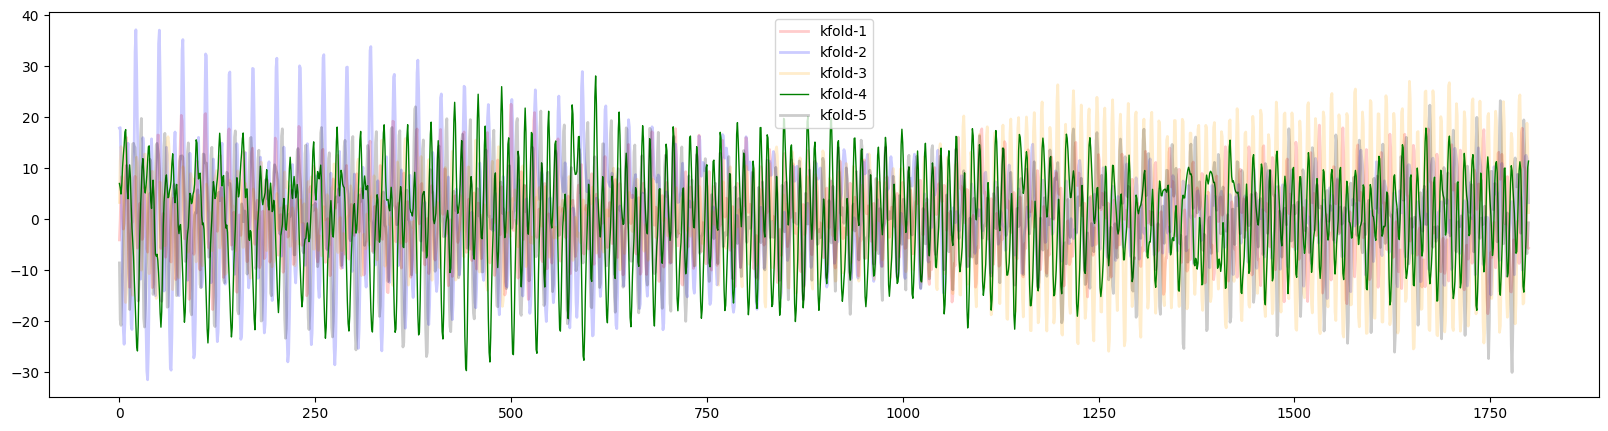

In [38]:
# raw_dataset = {'train', 'val'}
colors = ['red', 'blue', 'orange', 'green', 'black']
alphas = [.2, .2, .2, 1, .2]
linewidths = [2, 2, 2, 1, 2]
plt.figure(figsize=(20,5))

for i, val in enumerate(raw_dataset['val']):
    plt.plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=linewidths[i], alpha=alphas[i], label=f'kfold-{i+1}')

plt.legend()
plt.show()

/tmp/ipykernel_275413/3762171299.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  axs[i].plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=2, alpha=alphas[i], label=f'kfold-{i+1}')


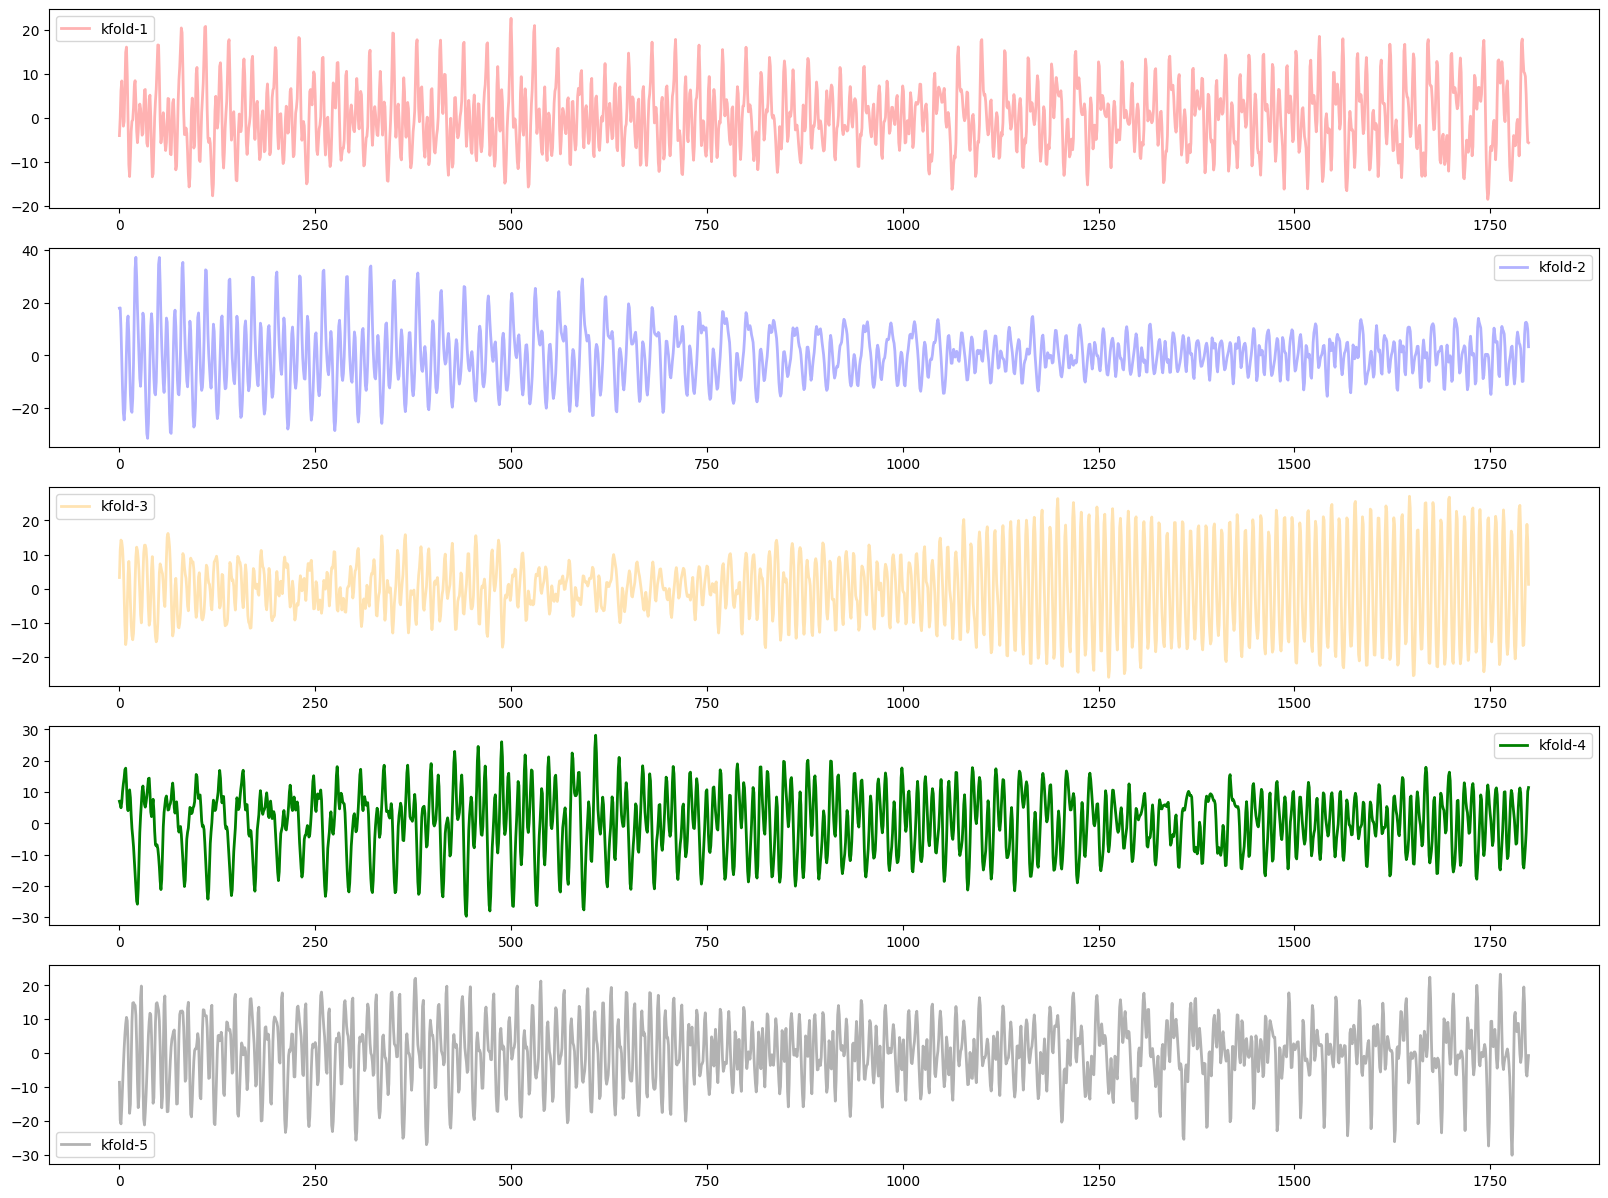

In [39]:
# raw_dataset = {'train', 'val'}
colors = ['red', 'blue', 'orange', 'green', 'black']
alphas = [.3, .3, .3, 1, .3]
fig, axs = plt.subplots(5,1,figsize=(20,15))

for i, val in enumerate(raw_dataset['val']):
    axs[i].plot(np.mean(np.asarray(val)[:, 0]), c=colors[i], linewidth=2, alpha=alphas[i], label=f'kfold-{i+1}')
    axs[i].legend()

plt.show()